In [1]:
from __future__ import print_function, division

%load_ext jupyternotify

import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import datasets, models
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from data import dataset

plt.ion()

torch.set_num_threads(8)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<IPython.core.display.Javascript object>

In [2]:
def top_k(model, input_, top=3):
    probs = torch.softmax(model(Variable(input_)), dim=1)
    top_probs, top_labs = probs.topk(top)
    top_probs = top_probs.detach().numpy().tolist()[0] 
    top_labs = top_labs.detach().numpy().tolist()[0]
    top_labels = [data['classes'][lab] for lab in top_labs]
    input, label = next(iter(data['test']))
    
    out = ''
    for prob, label in zip(top_probs, top_labels):
        out += label + '->' + str(round(prob, 2)) + "\n"
    return out

In [3]:
def imshow(inp, title=None):
    'Function that plots an images'
    
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [4]:
def visualize_model(model, num_images, data, class_names):
    '''
    Function that takes a batch of the dataset and plot them with the prediction
    
    Parameters:
    
    model -> Model that will be used to predict the images
    num_images -> Num of images that will be ploted
    data -> Data that will be used to visualize the predictions of the model
    class_names -> Dictionary that maps a number to a class of the model
    '''
    
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data):
            inputs = inputs.to(device)
            labels = labels.to(device)
            class_ = Variable(labels)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {0} \n correct: {1} \n Top 3:\n {2}'.format(class_names[preds.item()], class_names[class_.item()],  top_k(model, inputs, top=3)) )
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [5]:
def check_accuracy(model, data):
    '''
    Function that measures the accuracy of a model
    
    Parameters
        model -> The model to be evaluated.
        data -> The data that will be used to evaluate the model.
    '''
    
    num_correct = 0
    num_samples = 0
    model.eval()
    for x, y in data:
        
        with torch.no_grad():
            
            y = y.view(-1, 1).type(torch.LongTensor)
            x_var = Variable(x)
            scores = model(x_var)
            _, preds = scores.data.cpu().max(1)
        
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    
    return int(100 * acc)

In [6]:
def accuracy_per_class(model, data, classes):
    '''
    Function that measures the accuracy of a model per class
    
    Parameters
        model -> The model to be evaluated.
        data -> The data that will be used to evaluate the model.
        classes -> Dictionary that maps a number to a class of the model
    '''
     
    model.eval()
    confusion_matrix = torch.zeros(len(classes), len(classes))

    _classes = []
    _preds = []
    predicted_labels = []
    loocv_probs = []

    with torch.no_grad():
        
        for i, (inputs, labels) in enumerate(data):
            
            tmp_labels = model(inputs)
            classes_list = labels.cpu().detach().numpy().tolist()
            _classes[:]=[i+1 for i in classes_list]
            outputs = model(inputs)

            gpu_tensor_probs = F.softmax(outputs, 1)
            cpu_numpy_probs = gpu_tensor_probs.data.cpu().numpy()
            loocv_probs.append(cpu_numpy_probs.tolist())

            _, preds = torch.max(outputs, 1)
            preds_list = preds.cpu().detach().numpy().tolist()
            _preds[:]=[i+1 for i in preds_list]

            predicted_labels.append(preds.cpu().detach().numpy().tolist())
            for t, p in zip(labels.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1

    for i in range(0, len(classes)):
        total = int(confusion_matrix.sum(dim=1)[i].numpy())
        correct = int(confusion_matrix[i][i].numpy())
        acc = (confusion_matrix.diag()/confusion_matrix.sum(1))[i]*100
        class_ = classes[i]
        print(F'Class {class_} --> accuracy: {round(acc.item(), 2)}, correct predictions: {correct}, all: {total}\n')

In [7]:
data = dataset('artist', bs_train=1, bs_test=1, bs_valid=1)
num_classes = len(data['classes'])

train: 3650 valid: 567 test: 567


In [8]:
trained = True
model = models.alexnet(pretrained=trained)
model_type = type(model).__name__
print (model_type)

AlexNet


In [9]:
if trained:
    print ("Freezing layers")
    for param in model.parameters():
            param.requires_grad = False

last_layer = None
if model_type == 'AlexNet':
    num_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_ftrs, num_classes)
    last_layer = model.classifier[6]
elif model_type == 'ResNet':
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    last_layer = model.fc
    
model = model.to(device)

Freezing layers


In [10]:
#Loading a trained model
name = 'AlexNet_True_artist_t10_v5_c10_acc74_min4'
nn_dict = torch.load(F"{model_type}/{name}.pth")
model.load_state_dict(nn_dict, strict=False)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [11]:
check_accuracy(model, data['train'])

KeyboardInterrupt: 

In [12]:
check_accuracy(model, data['valid'])

Got 526 / 567 correct (92.77)


92

In [12]:
check_accuracy(model, data['test'])

Got 420 / 567 correct (74.07)


74

In [13]:
accuracy_per_class(model, data['test'], data['classes'])

Class Claude Monet --> accuracy: 89.47, correct predictions: 51, all: 57

Class Fernand Leger --> accuracy: 93.48, correct predictions: 43, all: 46

Class Henri Matisse --> accuracy: 61.82, correct predictions: 34, all: 55

Class Marc Chagall --> accuracy: 68.66, correct predictions: 46, all: 67

Class Pablo Picasso --> accuracy: 62.3, correct predictions: 38, all: 61

Class Peter Paul Rubens --> accuracy: 79.07, correct predictions: 34, all: 43

Class Pierre-Auguste Renoir --> accuracy: 80.36, correct predictions: 45, all: 56

Class Rembrandt --> accuracy: 83.87, correct predictions: 52, all: 62

Class Salvador Dali --> accuracy: 60.87, correct predictions: 42, all: 69

Class Vincent van Gogh --> accuracy: 68.63, correct predictions: 35, all: 51



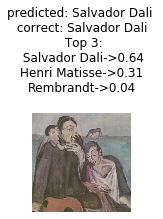

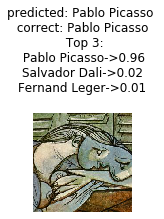

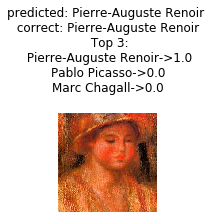

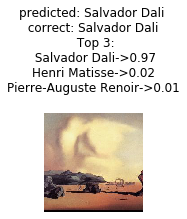

In [16]:
visualize_model(model, 4, data['test'], data['classes'])